In [ ]:
#Script to obtain data 
#from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential, Model
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

import pickle
from tensorflow.python.keras.saving import saving_utils
from tensorflow.python.keras.layers import deserialize, serialize

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
df = pd.read_csv("english_songs_new.csv")

In [ ]:
df = df.sample(frac=1)

In [ ]:
len(df)

1374

In [ ]:
col_features = df.columns[4:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [ ]:
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
12,Calm,0
0,Energetic,1
2,Happy,2
5,Sad,3


In [ ]:
def base_model():
    #Create the model
    model = Sequential()
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer 
    model.add(Dense(10,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [ ]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=1000,batch_size=200,verbose=0)

In [ ]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=20,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Baseline: 73.45% (5.65%)


In [ ]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


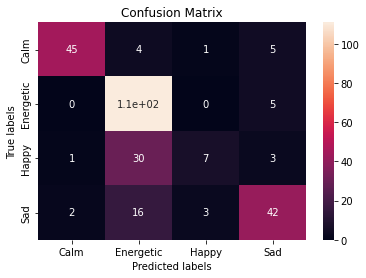

Accuracy Score 0.7454545454545455


In [ ]:
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [ ]:
#Join the model and the scaler in a Pipeline
pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                             batch_size=200,verbose=0))])
#Fit the Pipeline
pip.fit(X2,encoded_y)

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('keras',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb111530310>)],
         verbose=False)

In [ ]:
#df_hindi = pd.read_csv("indian_songs_unannotated.csv")
df_chinese = pd.read_csv("chinese_songs_unannotated.csv")

In [ ]:
playlist_features_list = ["id","artist", "album", "name", "length",	
                                "danceability","acousticness", "energy", "instrumentalness", "liveness", "valence",	"loudness",	"speechiness", "tempo", "key", "time_signature", "mood"]
playlist_dataframe = pd.DataFrame(columns = playlist_features_list)
playlist_features = {}

In [ ]:
for index,row in df_hindi.iterrows():
    preds_features = np.array(row[6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)
    mood = np.array(target['mood'][target['encode']==int(results)])
    row["mood"] = mood[0]
    playlist_features["mood"] = row["mood"]
    for feature in playlist_features_list[:-1]:
            playlist_features[feature] = row[feature]
    track_dataframe = pd.DataFrame(playlist_features, index = [0])
    playlist_dataframe = pd.concat([playlist_dataframe, track_dataframe], ignore_index = True)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
len(playlist_dataframe)

431

In [ ]:
playlist_dataframe.to_csv('hindi_songs_annotated.csv',encoding='utf-8')

In [ ]:
playlist_features_list = ["id","artist", "album", "name", "length",	
                                "danceability","acousticness", "energy", "instrumentalness", "liveness", "valence",	"loudness",	"speechiness", "tempo", "key", "time_signature", "mood"]
playlist_dataframe = pd.DataFrame(columns = playlist_features_list)
playlist_features = {}

for index,row in df_chinese.iterrows():
    preds_features = np.array(row[5:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)
    mood = np.array(target['mood'][target['encode']==int(results)])
    row["mood"] = mood[0]
    playlist_features["mood"] = row["mood"]
    for feature in playlist_features_list[:-1]:
            playlist_features[feature] = row[feature]
    track_dataframe = pd.DataFrame(playlist_features, index = [0])
    playlist_dataframe = pd.concat([playlist_dataframe, track_dataframe], ignore_index = True)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
playlist_dataframe.to_csv('chinese_songs_annotated.csv',encoding='utf-8')